In [4]:
import pandas as pd
import numpy as np
import random
import time

In [2]:
df = pd.read_csv('BA_AirlineReviews.csv')

In [3]:
df.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [4]:
df.shape

(3701, 20)

delete the first column because it's just an index that exists already (sequestial numbering)

In [5]:
df.drop(columns = df.columns[0], axis=1, inplace=True)

## Analysis and Visualization

<AxesSubplot:xlabel='SeatType', ylabel='count'>

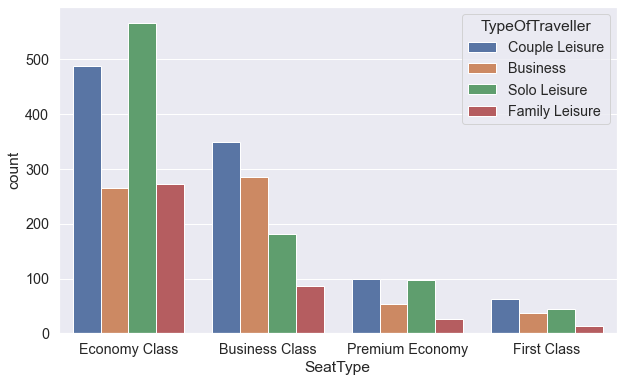

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (10, 6))
sns.set(font_scale=1.3)


sns.countplot(x=df.SeatType, hue=df.TypeOfTraveller)


<AxesSubplot:xlabel='TypeOfTraveller', ylabel='count'>

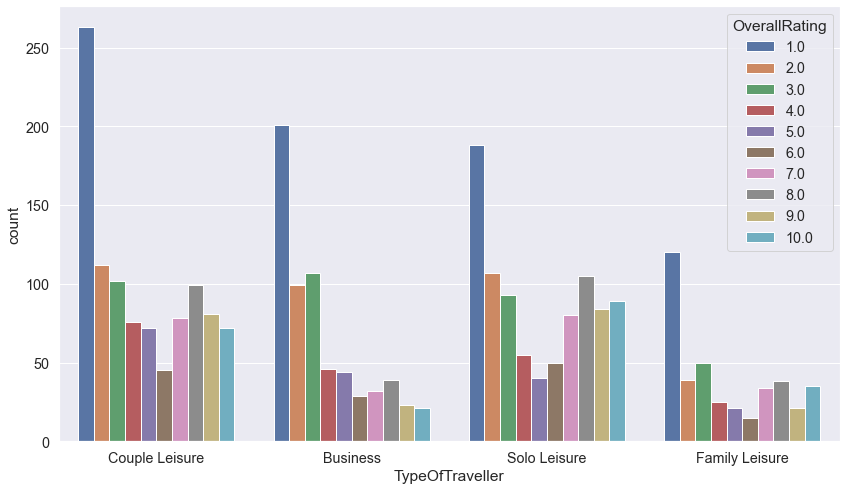

In [7]:
plt.figure(figsize = (14, 8))

sns.countplot(x=df.TypeOfTraveller, hue=df.OverallRating)

Text(0.5, 1.0, 'Overall Rating for First Class Seat')

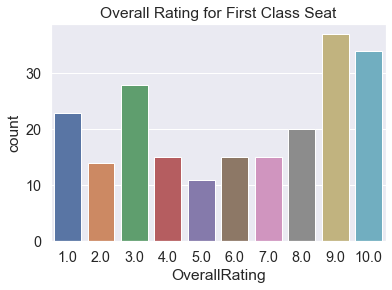

In [9]:
sns.countplot(x='OverallRating', data=df.loc[df['SeatType']=='First Class'])
plt.title('Overall Rating for First Class Seat')

In [48]:
df[['SeatType','SeatComfort']].groupby(['SeatType']).mean().sort_values(by = 'SeatComfort')

,SeatComfort
SeatType,
Economy Class,2.729144
Business Class,2.911338
Premium Economy,3.042614
First Class,3.688679


It's clear that the First Class had the biggest mean of SeatComfort ratings, then Premium Economy Class,...

Let's see now how the Cabine stuff behaves with the different types of traveller

<AxesSubplot:xlabel='TypeOfTraveller', ylabel='CabinStaffService'>

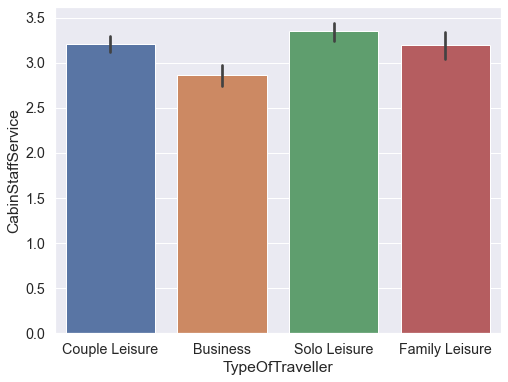

In [51]:
plt.figure(figsize=(8, 6))

sns.barplot(x='TypeOfTraveller', y='CabinStaffService', data=df)

We can conclude that all of traveller types have the same rating about the cabine stuff service.

<AxesSubplot:xlabel='SeatType', ylabel='Food&Beverages'>

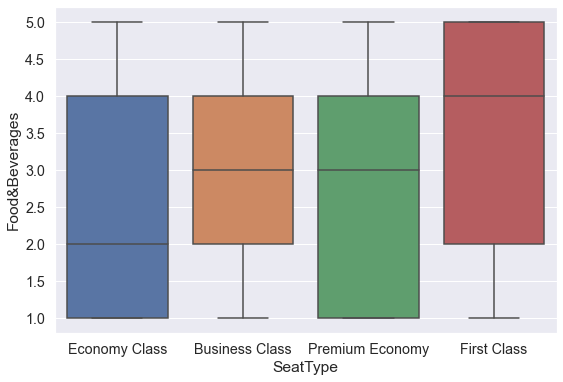

In [55]:
plt.figure(figsize=(9,6))

sns.boxplot(x='SeatType', y='Food&Beverages', data=df)

Let's finish be seeing how much recommandations we got for each aircraft in this dataset:

In [77]:
df['Aircraft'].describe()

count     1922
unique     202
top       A320
freq       366
Name: Aircraft, dtype: object

As you can see, there is just 1922 elements not null of 3700, and 202 aircraft unique values. We cannot visualise them all in one plot. We gonna shoose just the top 10 aircraft. 

Here is another method to see the number of unique values of this column:

In [28]:
df['Aircraft'].nunique()

202

In [18]:
df['Aircraft'].value_counts()

A320                     366
Boeing 777               272
Boeing 747-400           182
A380                     166
Boeing 777-200           125
                        ... 
A319 / Boeing 787-9        1
Boeing 747-400 / A319      1
A320 / Boeing 747-400      1
Boeing 777 / A380          1
Airbus 319                 1
Name: Aircraft, Length: 202, dtype: int64

In [19]:
df.loc[(df.Recommended == 'yes'), 'Aircraft'].value_counts()

A320                         160
Boeing 777                    99
A380                          86
Boeing 747-400                80
Boeing 777-200                58
                            ... 
Boeing 747 and Boeing 777      1
Boeing 777 / A380              1
A319 / Boeing 787-9            1
Airbus A32                     1
Airbus 319                     1
Name: Aircraft, Length: 133, dtype: int64

So, now we can take just the index of the 10 first ones

In [15]:
aircraft_10 = df.loc[(df.Recommended == 'yes'), 'Aircraft'].value_counts().iloc[:10].index # we can use also .head(10) instead of iloc[:10]

<AxesSubplot:xlabel='Aircraft', ylabel='count'>

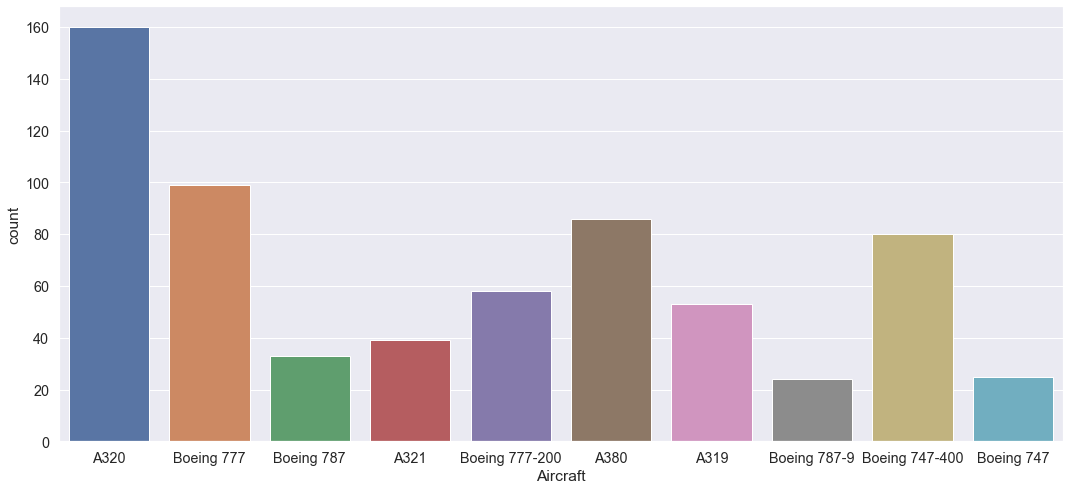

In [24]:
plt.figure(figsize = (18, 8))

sns.countplot(x='Aircraft', data=df.loc[(df.Recommended == 'yes') & (df.Aircraft.isin(aircraft_10)), :])

## Data Cleaning

Let's see how much Null data do we have in each column

In [13]:
df.isnull().sum()

OverallRating               5
ReviewHeader                0
Name                        0
Datetime                    0
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           771
SeatType                    2
Route                     775
DateFlown                 778
SeatComfort               116
CabinStaffService         127
GroundService             846
ValueForMoney               1
Recommended                 0
Aircraft                 1779
Food&Beverages            386
InflightEntertainment    1150
Wifi&Connectivity        3092
dtype: int64

## Data Augmentation with MLM with fill-mask

In [1]:
from transformers import pipeline

fillmask = pipeline("fill-mask", model="roberta-base")
mask_token = fillmask.tokenizer.mask_token

In [2]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

In [3]:
def mask_sentence(sentence, min_mask, ignore_stop_words=False):
    """
    min_mask paramter is for the minimum number of masked tokens, and the number itself then, is choosen randomly
    The number of words of the sentence should be at least 3 else, an error will be raised
    The last parameter ignore_stop_words is for activating or desactivating masking stop words
    """
    words = sentence.split(' ')
    try:
        fraction = 3 if len(words) > 5 else 2
        k_list = random.sample(range(0, len(words), 3), random.randint(min_mask, int(len(words)/fraction)))
        
        for k in k_list:
                masked_sentence_list = words[:k] + [mask_token] + words[k+1:]
                words = masked_sentence_list
        
        if ignore_stop_words == True:
            words = sentence.split(' ')
            all_stop_words = True
            for k in k_list:
                if words[k].lower() not in list(stop_words):
                    all_stop_words = False
            if all_stop_words == False:
                for k in k_list:
                    if words[k].lower() not in list(stop_words):     
                        masked_sentence_list = words[:k] + [mask_token] + words[k+1:]
                        words = masked_sentence_list
        
        return " ".join(masked_sentence_list)

    except ValueError:
        if len(sentence) < 3:
            print("ERROR: The number of words of the sentence should be at least 3")
        else:
            print(f"ERROR: The minimum number of mask tokens that you specified is so high,\n\tIt should be less than or equal to {int(len(words)/3)}")

In [6]:
test = "The number of words"
mask_sentence(test, 2, False)

'<mask> number of <mask>'

In [8]:
test = "The number of words"
mask_sentence(test, 2, True)

'The number of <mask>'

In the above example, just the first and fourth words can be masked, but since the first one is a stop word, so just the second word have been masked.

In [7]:
def predict_mask_tokens(masked_sentence):
    for _ in range(masked_sentence.count('<mask>')):
        predictions = fillmask(masked_sentence)
        try:
            masked_sentence = predictions[random.randint(0,4)]['sequence']
        except Exception:
            masked_sentence = predictions[0][random.randint(0,4)]['sequence']
    return masked_sentence

In [15]:
def predict_mask_tokens(masked_sentence):
    predictions = fillmask(masked_sentence)
    for i in range(masked_sentence.count('<mask>')):
        masked_sentence = masked_sentence.replace('<mask>', predictions[i][random.randint(0,4)]['token_str'], 1)
    return masked_sentence

## Data Augmentation with MLM with customization

In [17]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForMaskedLM.from_pretrained('roberta-base')

In [2]:
def mask_sentence_2(sentence, min_mask, ignore_stop_words=False):
    """
    min_mask paramter is for the minimum number of masked tokens, and the number itself then, is choosen randomly
    The number of words of the sentence should be at least 3 else, an error will be raised
    The last parameter ignore_stop_words is for activating or desactivating masking stop words
    """
    words = sentence.split(' ')
    try:
        fraction = 3 if len(words) > 5 else 2
        k_list = random.sample(range(0, len(words), 3), random.randint(min_mask, int(len(words)/fraction)))
        
        for k in k_list:
                masked_sentence_list = words[:k] + [tokenizer.mask_token] + words[k+1:]
                words = masked_sentence_list
        
        if ignore_stop_words == True:
            words = sentence.split(' ')
            all_stop_words = True
            for k in k_list:
                if words[k].lower() not in list(stop_words):
                    all_stop_words = False
            if all_stop_words == False:
                for k in k_list:
                    if words[k].lower() not in list(stop_words):     
                        masked_sentence_list = words[:k] + [tokenizer.mask_token] + words[k+1:]
                        words = masked_sentence_list
        
        return " ".join(masked_sentence_list)

    except ValueError:
        if len(sentence) < 3:
            print("ERROR: The number of words of the sentence should be at least 3")
        else:
            print(f"ERROR: The minimum number of mask tokens that you specified is so high,\n\tIt should be less than or equal to {int(len(words)/3)}")

In [62]:
sentence_exemple_2 = "The number of words"
masked_sentence_2 = mask_sentence_2(sentence_exemple_2, 1)
masked_sentence_2

'<mask> number of <mask>'

In [63]:
input_seq = tokenizer.encode(masked_sentence_2, max_length=512, truncation=True, return_tensors='pt')
mask_tokens_indexes = torch.where(input_seq == tokenizer.mask_token_id)[1]

In [64]:
mask_tokens_indexes

tensor([1, 4])

In [65]:
logits = model(input_seq).logits
masked_token_logits = logits[0, mask_tokens_indexes]

There are two masked tokens, we can refer to the first one by **.indices[0]**, and so on.

In [73]:
top5_tokens = torch.topk(masked_token_logits, 5).indices[0]

In [74]:
tokenizer.decode(top5_tokens[0])

'Total'

In [75]:
tokenizer.decode(torch.topk(masked_token_logits, 3).indices[1][0])

' users'

Now, let's create a function that automatically replace all masked tokens by one of the top 3 predictions

In [77]:
def predict_mask_tokens_2(masked_sentence):
    input_seq = tokenizer.encode(masked_sentence, max_length=512, truncation=True, return_tensors='pt')
    masked_tokens_indexes = torch.where(input_seq == tokenizer.mask_token_id)[1]
    
    logits = model(input_seq).logits
    masked_tokens_logits = logits[0, masked_tokens_indexes]
   
    for i in range(len(masked_tokens_indexes)):
        masked_sentence = masked_sentence.replace('<mask>', tokenizer.decode(torch.topk(masked_tokens_logits, 3).indices[i][random.randint(0,2)]), 1)
    return masked_sentence

### Test of the speed of each method on a sentence of 34 words

In [13]:
sentence = "4 Hours before takeoff we received a Mail stating a cryptic message that there are disruptions to be expected as \
there is a limit on how many planes can leave at the same time."

In [85]:
len(sentence.split(' '))

34

In [18]:
masked_sentence = mask_sentence_2(sentence, 4)
masked_sentence

'4 Hours before <mask> we received a Mail stating <mask> cryptic message that there are disruptions to be <mask> as there <mask> a limit <mask> how many <mask> can leave at the same <mask>'

In [19]:
start_time = time.time()
print(predict_mask_tokens(masked_sentence))
print(time.time()-start_time)

4 Hours before, we received a Mail stating this cryptic message that there are disruptions to be experienced as there is a limit on how many people can leave at the same hour
0.5479986667633057


In [97]:
start_time = time.time()
print(predict_mask_tokens_2(masked_sentence_2))
print(time.time()-start_time)

- Hours before  departure we received a Mail stating  the cryptic message that there are  flights to be  delays as there 's a limit  of how many planes can leave  at the same  flight
0.08852934837341309


### Test of the speed of each method on a sentence of the longest sentence (654 words)

I cannot test the first approach on the longest sentence because it doesn't involve the truncation operation, and I don't know exactly the maximum number of words accepted (512 is the number of tokens and they are not necessarily the words).

I tryed many ones, and I successed finaly to find a sentence with **308 words** that worked.
 
I tested the second approach with the longest sentence without any problems, because it gonna be truncated if it exceed the token limit of RoBERTa.

In [81]:
sen_len = df['ReviewBody'].apply(lambda x: len(x.split(' ')))

In [112]:
sen_len[(sen_len >= 300) & (sen_len <= 400)]

12      308
25      300
47      362
53      348
65      375
       ... 
3591    368
3606    327
3610    357
3641    308
3648    377
Name: ReviewBody, Length: 229, dtype: int64

In [129]:
sentence_308 = df['ReviewBody'][3641]

In [130]:
sentence_masked_308 = mask_sentence_2(sentence_308, 10)
sentence_masked_308

'<mask> - Johannesburg <mask> My first <mask> on A380. <mask> half an hour delay because <mask> planes late <mask> boarding started. <mask> thing I <mask> was how <mask> the seats <mask> Second thing to notice is <mask> the plane <mask> not properly <mask> There were <mask> stains and <mask> cans left <mask> At this point I noticed some toilet paper <mask> the panels <mask> my head. <mask> asked the <mask> crew explained <mask> is how <mask> fixed condensation <mask> from the <mask> conditioning. Anyhow <mask> for lift <mask> I turned on the inflight <mask> system to <mask> it from <mask> camera at <mask> tail of <mask> plane. After <mask> for 5 <mask> I couldn\'t <mask> it anywhere. <mask> I found <mask> there is <mask> such option <mask> BA A380s). <mask> no tail <mask> fine let\'s <mask> to some <mask> Wrong the <mask> are not <mask> Cabin crew <mask> me they will "bring me <mask> more". One <mask> later suffice <mask> to say <mask> crew did <mask> bring anything. I\'ve managed to <

In [131]:
start_time = time.time()
print(predict_mask_tokens(sentence_masked_308))
print(time.time()-start_time)

5 - Johannesburg. My first stop on A380. After half an hour delay because 2 planes late, boarding started.First thing I noted was how comfortable the seats were Second thing to notice is how the plane was not properly washed There were some stains and garbage cans left out At this point I noticed some toilet paper under the panels behind my head. After asked the airline crew explained that is how the fixed condensation comes from the air conditioning. Anyhow, for lift time I turned on the inflight sound system to see it from my camera at a tail of my plane. After trying for 5 hours I couldn't see it anywhere. Eventually I found out there is one such option on BA A380s). Still no tail sounds fine let's move to some. Wrong the seats are not available Cabin crew tell me they will "bring me 2 more". One day later suffice it to say Cabin crew did actually bring anything. I've managed to add a pair more unused headphones into one empty ear just to figure out they're not working? Probably it'

In [132]:
start_time = time.time()
print(predict_mask_tokens_2(sentence_masked_308))
print(time.time()-start_time)

1 - Johannesburg : My first  trip on A380.  About half an hour delay because  the planes late  as boarding started.  First thing I  saw was how  uncomfortable the seats . Second thing to notice is  how the plane  cooled not properly ! There were  food stains and  beer cans left . At this point I noticed some toilet paper  on the panels  above my head.  When asked the  flight crew explained  this is how  they fixed condensation  leaks from the  cabin conditioning. Anyhow  waiting for lift  tickets I turned on the inflight  entertainment system to  view it from  my camera at  the tail of  my plane. After  sitting for 5  minutes I couldn't  hear it anywhere.  Then I found  out there is  one such option  with BA A380s).  If no tail , fine let's  go to some ! Wrong the  lights are not  working Cabin crew  tells me they will "bring me  one more". One  hour later suffice 's to say  cabin crew did  NOT bring anything. I've managed to  find a pair  my unused headphones  in one empty  one just t

The difference in time execution is **crazy**

In [139]:
longest_sentence_index = sen_len[sen_len == sen_len.max()].index[0]

In [140]:
longest_sentence = df['ReviewBody'][longest_sentence_index]

In [141]:
longest_sentence_masked = mask_sentence_2(longest_sentence, 10)
longest_sentence_masked

"<mask> Kong to <mask> via London. <mask> whole experience <mask> a nightmare <mask> me and <mask> wife. My <mask> lost her <mask> ever since <mask> first day <mask> our journey <mask> 1st August <mask> our two <mask> of luggage <mask> left in <mask> Airport by <mask> staff when <mask> took the <mask> flight from <mask> UK to <mask> We went <mask> Menzies in <mask> and they <mask> a repor. <mask> stated in <mask> missing report <mask> if the <mask> was found, <mask> should be <mask> to our <mask> b&b house <mask> Marstal in <mask> on or <mask> 3rd August <mask> deliver to <mask> hotel we <mask> in CPH <mask> they were <mask> on 4th <mask> On 2nd <mask> we found <mask> the updated <mask> of our <mask> luggage in <mask> BA website <mask> that one <mask> our luggage <mask> found while <mask> one had <mask> possible match. <mask> we kept <mask> and emailing <mask> staff to <mask> them to <mask> the luggage <mask> our house <mask> they failed <mask> do so. <mask> the website <mask> showed t

In [142]:
start_time = time.time()
print(predict_mask_tokens_2(longest_sentence_masked))
print(time.time()-start_time)

 Hong Kong to  Bangkok via London. This whole experience  was a nightmare  for me and  the wife. My  wife lost her  passport ever since  that first day  of our journey . 1st August  2016 our two  sets of luggage  got left in  Bangkok Airport by  the staff when  they took the  first flight from  the UK to  China We went  to Menzies in  HK and they  sent a repor.  It stated in  the missing report  and if the  luggage was found,  it should be  taken to our  friends b&b house , Marstal in  Bangkok on or  around 3rd August  or deliver to  the hotel we  stayed in CPH  as they were  due on 4th . On 2nd  August we found  that the updated  list of our  missing luggage in  the BA website  shows that one  match our luggage  got found while  other one had  no possible match.  While we kept  asking and emailing  the staff to  ask them to  deliver the luggage  in our house  and they failed 't do so.  But the website  it showed that  we chose to  pick up the  luggage in the  UK which was  not our pre

As we can see, even for the longest sentence, it takes just **1,84 seconds** for predictions all masked tokens. 

In [143]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(sentence)

print(sentence)
print(augmented_text)

c:\Users\Anas\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


4 Hours before takeoff we received a Mail stating a cryptic message that there are disruptions to be expected as there is a limit on how many planes can leave at the same time.
['quartet Hours before takeoff we received a Postal service stating a cryptic substance that there are hoo hah to make up expected as there is a limit on how many planes can leave at the like metre.']


## Sentiment Analysis of customers based on their reviews

In [9]:
import torch
from transformers import BertTokenizer,BertForSequenceClassification
from sklearn.model_selection import train_test_split

In [6]:
df['OverallRating'].unique()

array([ 1.,  3.,  8.,  7.,  2.,  6.,  4.,  5., 10.,  9., nan])

In [7]:
df['OverallRating'].isnull().sum()

5

In [22]:
df2 = df[['OverallRating', 'ReviewBody']].dropna()

In [23]:
new_lines = []
for sentence, label in zip(df2['ReviewBody'][20:50], df2['OverallRating'][20:50]):
    if len(sentence.split(' ')) <= 512:
        new_lines.append([predict_mask_tokens(mask_sentence(sentence, 4)), label])
        
#df2_extension = pd.DataFrame(new_lines, columns =df2.columns)

In [24]:
sen_len= df2['ReviewBody'].apply(lambda x: len(x.split(' ')))

In [49]:
intervals = []
for l in sen_len:
    if l <= 100:
        intervals.append('0 - 100')
    elif l <= 200:
        intervals.append('100 - 200')
    elif l <= 300:
        intervals.append('200 - 300')
    elif l <= 400:
        intervals.append('300 - 400')
    elif l <= 500:
        intervals.append('400 - 500')
    else:
        intervals.append('> 500')

In [56]:
sen_intervals = pd.DataFrame({'length':list(sen_len), 'interval': intervals})

Text(0.5, 0, 'Length of Sentences')

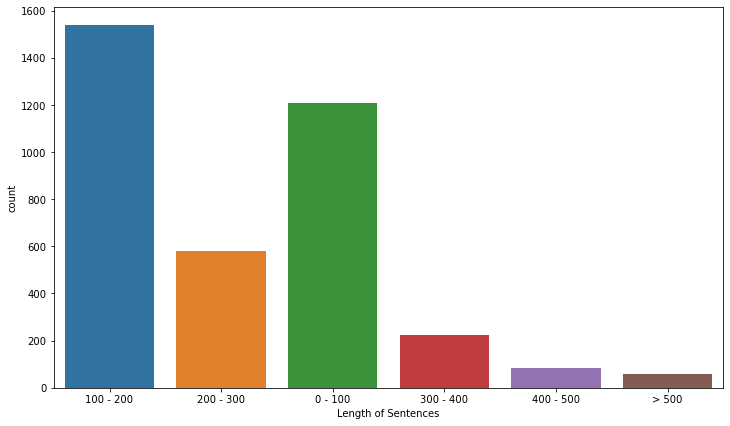

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.countplot(x='interval', data=sen_intervals)

plt.xlabel('Length of Sentences')

In [211]:
df2_extension = pd.DataFrame(new_lines, columns = ['ReviewBody', 'OverallRating'])

Let's hold the reviews with a nan rating to test our model on them after getting trained.

In [43]:
test_reviews = list(df.loc[(df['OverallRating'].isna()), 'ReviewBody'])

### Label Encoding and Splitting the Data

Now, let's encode these target values using LabelEncoding

In [20]:
from sklearn.preprocessing import LabelEncoder

labEnc = LabelEncoder()
target_labels = labEnc.fit_transform(df2['OverallRating'])

In [21]:
X = list(df2['ReviewBody'])
y = list(target_labels)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

We add **stratify** to ensure that the splitting of data maintains the proportion of the target variable classes in both the training and validation sets. 

An alternative to the train_test_split function is using cross-validation (such as K-Fold or Stratified Cross-Validation). Cross-validation involves splitting the dataset into multiple subsets and iterate over each subset as both a training and testing set. It provides a more robust evaluation of the model’s performance by utilizing the entire dataset for training and testing.

### Tokenization and Creating the Datasets

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We choosed here the model 'bert-base-uncased' because we want a reasonably sized (**base**), case-insensitive (**uncased**) BERT model that doesn't require high computational resources.

In [47]:
tokenizer.model_max_length

512

In [23]:
X_train_encoding = tokenizer(X_train, padding=True, max_length=512, truncation=True)
X_val_encoding = tokenizer(X_val, padding=True, max_length=512, truncation=True)

In [49]:
X_train_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

+ **Padding = True:** means that the tokenizer will pad the shorter sequences so that they have the same length as the longest sequence. If the max_length is specified (as in our case), they will have all this length. It gonna do so, by adding <pad> token.
+ **truncation = True:** The sentences that exceed the max_length will be truncated to have this length by removing characters from the end of each of these sequence.
+ So, the max_length influences both the padding and the truncation.
+ And finally why we used 512 as a max length, this is because the pre-trained transformer model BERT has a **maximum token limit of 512** as you can see above.

In [24]:
from datasets import Dataset

train_dataset = Dataset.from_dict({**X_train_encoding, "labels" : y_train})
val_dataset = Dataset.from_dict({**X_val_encoding, "labels" : y_val})

The resulting dictionary that we pass into the from_dict() function has the tokenized input features such as "*input_ids*" and "*attention_mask*",  along with the additional "*label*" key, which is suitable for creating a **Dataset object**.

### Defining the model and the evaluation metrics

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [30]:
model = model.to('cpu')

It means that we are moving our model to **GPU** to faster training by taking advantage from the parallelizable computations handled by it.

In [25]:
if torch.cuda.is_available():
    
    num_gpus = torch.cuda.device_count()
    current_gpu = torch.cuda.current_device()
    print(f"Number of GPUs available: {num_gpus}")
    print(f"Current GPU used: {current_gpu}")
    
    gpu_properties = torch.cuda.get_device_properties(0)
    print(f"GPU {current_gpu}: {gpu_properties.name}")
    print(f"\tCUDA Version: {torch.version.cuda}")
    print(f"\tCUDA Capability: {gpu_properties.major}.{gpu_properties.minor}")
    print(f"\tTotal Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
    print()

    print(f"Overall CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available.")

Number of GPUs available: 1
Current GPU used: 0
GPU 0: NVIDIA GeForce GTX 1650
	CUDA Version: 11.3
	CUDA Capability: 7.5
	Total Memory: 4.00 GB

Overall CUDA Version: 11.3


In [26]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Defining The Trainer

In [27]:
from transformers import TrainingArguments, Trainer, IntervalStrategy, EarlyStoppingCallback

In [29]:
print(np.__version__)

1.22.4


In [31]:
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="/content/drive/MyDrive/BertForSequenceClassification",  # Directory for saving model checkpoints and logs
        overwrite_output_dir=True,
        evaluation_strategy=IntervalStrategy.STEPS, # It's more recommended to use this in newer transformers version instead of the "steps" string
        eval_steps=500, #  The number of times the entire training dataset will be processed by the model
        save_steps=500,          # the frequency at which the model checkpoints are saved during training, 1000 is the same value of the eval_batch_size
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=1e-5,
        weight_decay=0.05,
        load_best_model_at_end = True
    ),
    train_dataset=train_dataset,  # Your training dataset
    eval_dataset=val_dataset,    # Your evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # to introduce early stopping to prevent overfitting
)

A **checkpoint** is a snapshot of the model's parameters and other relevant information at a particular point during training.

I'm using just one GPU, so there will be no **distributed training**. In distributed training, the training data is divided among the available GPUs, and each GPU processes a subset of the data independently. It allows you to take advantage of the parallel processing capabilities of multiple GPUs, potentially speeding up the training process compared to using a single GPU. If you have multiple GPUs, the **effective batch size** will be the product of *per_device_train_batch_size* and the number of GPUs. If you specify as well the *train_batch_size* parameter, it becomes the new effective batch size. So, it's up to you to ensure that it aligns with the available GPUs. It doesn't have to be equal to the effective batch size, but it needs to be a multiple of the effective batch size to distribute the workload evenly across GPUs.

In [15]:
total_steps = (len(X_train) / trainer.args.per_device_train_batch_size) * trainer.args.num_train_epochs
total_steps

1847.5

### Training the model

In [23]:
import torch
torch.cuda.empty_cache()

In [32]:
trainer.train()

c:\Users\Anas\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2956
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1850


  0%|          | 0/1850 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 4.00 GiB total capacity; 3.42 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF